In [1]:
import SimpleITK as sitk
import os
import glob
import numpy as np
import pydicom
import nibabel as nib
import pandas as pd
import time
import shutil

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import skimage
from skimage import data, measure
from skimage.io import imread
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border

from skimage.measure import regionprops
from skimage.morphology import closing, square

from skimage.color import label2rgb

from exp_utils import *
from model_utils import *
from utils import l2_regularisation



from data import *

from StitchingDeTr import *

import torchvision.transforms as T

import pickle
import torch
import torch.nn.functional as F
%matplotlib inline

In [ ]:
from HPUnet_torch import HierarchicalProbUNet

In [ ]:
base_channels = 12
num_convs_per_block = 3
default_channels_per_block = (
     base_channels,
	2* base_channels,
	 4*base_channels,
     8*base_channels,
	 8*base_channels,
	 8*base_channels,
    8*base_channels,
    8*base_channels,
8*base_channels)
input_channels = tuple([1])+tuple([i for i in default_channels_per_block])

channels_per_block = default_channels_per_block
down_channels_per_block = tuple([i / 2 for i in default_channels_per_block])
#net=Hierarchical_Core(dim=2,input_channels=list(input_channels),channels_per_block=list(channels_per_block),
#               down_channels_per_block=list(down_channels_per_block), convs_per_block=3,
#               blocks_per_level=3,Posterior=False)

#HPUnetscri=StitchingDecoder(dim=2,latent_dims=[1,1,1,1],input_channels=list(input_channels),channels_per_block=list(channels_per_block),num_classes=6,
#               down_channels_per_block=list(down_channels_per_block), convs_per_block=3,
#               blocks_per_level=3)


net=HierarchicalProbUNet(dim=2,latent_dims=[1,1,1,1],input_channels=list(input_channels),channels_per_block=list(channels_per_block),num_classes=2,
               down_channels_per_block=list(down_channels_per_block), convs_per_block=3,
               blocks_per_level=3)

In [ ]:
#path=r"C:\Users\youve\Dossier Thése\model_chkpointbest"
beta="beta10"
#best_model_path ="bestmodel_withgen_with_size128x128_"+beta+".pt" 
best_model_path="bestmodel_withgen_with_size256x256_beta1_30epochs.pt"

In [ ]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=0)
model=HierarchicalProbUNet(dim=2,latent_dims=[1,1,1,1],input_channels=list(input_channels),channels_per_block=list(channels_per_block),num_classes=2,
               down_channels_per_block=list(down_channels_per_block), convs_per_block=3,
               blocks_per_level=3)
#model, optimizer, start_epoch, valid_loss_min = load_ckp(checkpoint_path, model, optimizer)
model, optimizer, start_epoch, valid_loss_min = load_ckp(best_model_path, model, optimizer)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

In [ ]:
#start_epoch

In [ ]:
#valid_loss_min

In [ ]:
#

In [ ]:
data_test_dir=r'C:\Users\youve\Dossier Thése\model_chkpoint\test dataset'

In [2]:
data_dir=r'C:\GAINED\resampled_croped'

In [3]:
def get_path_modality_and_mask(data_dir):
    
    ls_idx_pet = list(map(lambda x:x.split('\\')[-1].split('_')[0] , glob.glob(data_dir +'\\'+ 'PET0\\*00001.nii*')))    
    ls_idx_mask = list(np.unique(np.array(list(map(lambda x:x.split('\\')[-1][:14], glob.glob(data_dir +'\\'+'PET0_mask*/*nii*'))))))
    #print(ls_idx_mask)
    #print(ls_idx_pet)
    ls_ids = sorted(list(set(ls_idx_pet).intersection(set(ls_idx_mask))))
        
    pt_path=[os.path.join(data_dir,'PET0',ids+'_00001.nii') for ids in ls_ids]
    
    mask_path=[os.path.join(data_dir,'PET0_masks',ids+'_mask.nii') for ids in ls_ids]
    
    
    return pt_path,mask_path

In [4]:
pt_path,mask_path=get_path_modality_and_mask(data_dir)

In [5]:
masks_dir = [dir_mask for dir_mask in os.listdir(data_dir) if 'masks' in dir_mask]

In [6]:
mask_path_llo=[m_path.replace('PET0_masks','PET0_masks_llo') for m_path in mask_path]
mask_path_lo=[m_path.replace('PET0_masks','PET0_masks_lo') for m_path in mask_path]

In [7]:
cst=100
test_mask_img=[]
for path in mask_path[1:10]:
    mask = nib.load(path).get_data()
    for i in range(mask.shape[1]):
        test_mask_img.append(mask[:,i,:])
        
test_mask_llo_img=[]
for path in mask_path_llo[1:10]:
    mask = nib.load(path).get_data()
    for i in range(mask.shape[1]):
        test_mask_llo_img.append(mask[:,i,:])

test_mask_lo_img=[]
for path in mask_path_lo[1:10]:
    mask = nib.load(path).get_data()
    for i in range(mask.shape[1]):
        test_mask_lo_img.append(mask[:,i,:])


test_pt_img=[]
for path in pt_path[1:10]:
    img = nib.load(path).get_data()
    img /= cst
    for i in range(img.shape[1]):
        test_pt_img.append(img[:,i,:])

C:\Users\youve\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  after removing the cwd from sys.path.
C:\Users\youve\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  # Remove the CWD from sys.path while we load stuff.
C:\Users\youve\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecate

In [8]:
desired_shape=(256,256)
good_slices = []
for ary in test_mask_img:
    count_zero = (ary == 0).sum()
    unique, counts = np.unique(ary, return_counts=True)
    p=counts[1:].sum()/count_zero
    good_slices.append(p)
    #print(dict(zip(unique, counts)))
x=dict(zip(good_slices,range(len(test_mask_img))))
best_slices_sorted={k: v for k, v in sorted(x.items(), key=lambda item: float(item[0]))}

In [9]:
best_slices_sorted

{0.0: 1151,
 3.051850947599719e-05: 960,
 6.103888176768602e-05: 857,
 9.156111704562795e-05: 1099,
 0.00012208521548040532: 845,
 0.00015261117724262125: 719,
 0.0001831390025028997: 718,
 0.00021366869143188546: 840,
 0.0002442002442002442: 961,
 0.00027473366097866236: 846,
 0.00030526894193784725: 862,
 0.00033580608724852705: 858,
 0.00036634509708145075: 717,
 0.00039688597160738817: 813,
 0.00042742871099713014: 848,
 0.0004579733154214881: 839,
 0.0004885197850512946: 715,
 0.0005190681200574028: 830,
 0.0005496183206106871: 861,
 0.0005801703868820422: 824,
 0.0006107243190423843: 592,
 0.00064128011726265: 962,
 0.0006718377817137971: 859,
 0.000702397312566804: 827,
 0.0007329587099926704: 860,
 0.0007635219741624164: 963,
 0.0007940871052470833: 837,
 0.0008246541034177331: 831,
 0.000855222968845449: 836,
 0.0008857937017013348: 820,
 0.0009163663021565154: 835,
 0.0009469407703821364: 480,
 0.0009775171065493646: 828,
 0.0010998411340584137: 978,
 0.0011610143599144515: 1

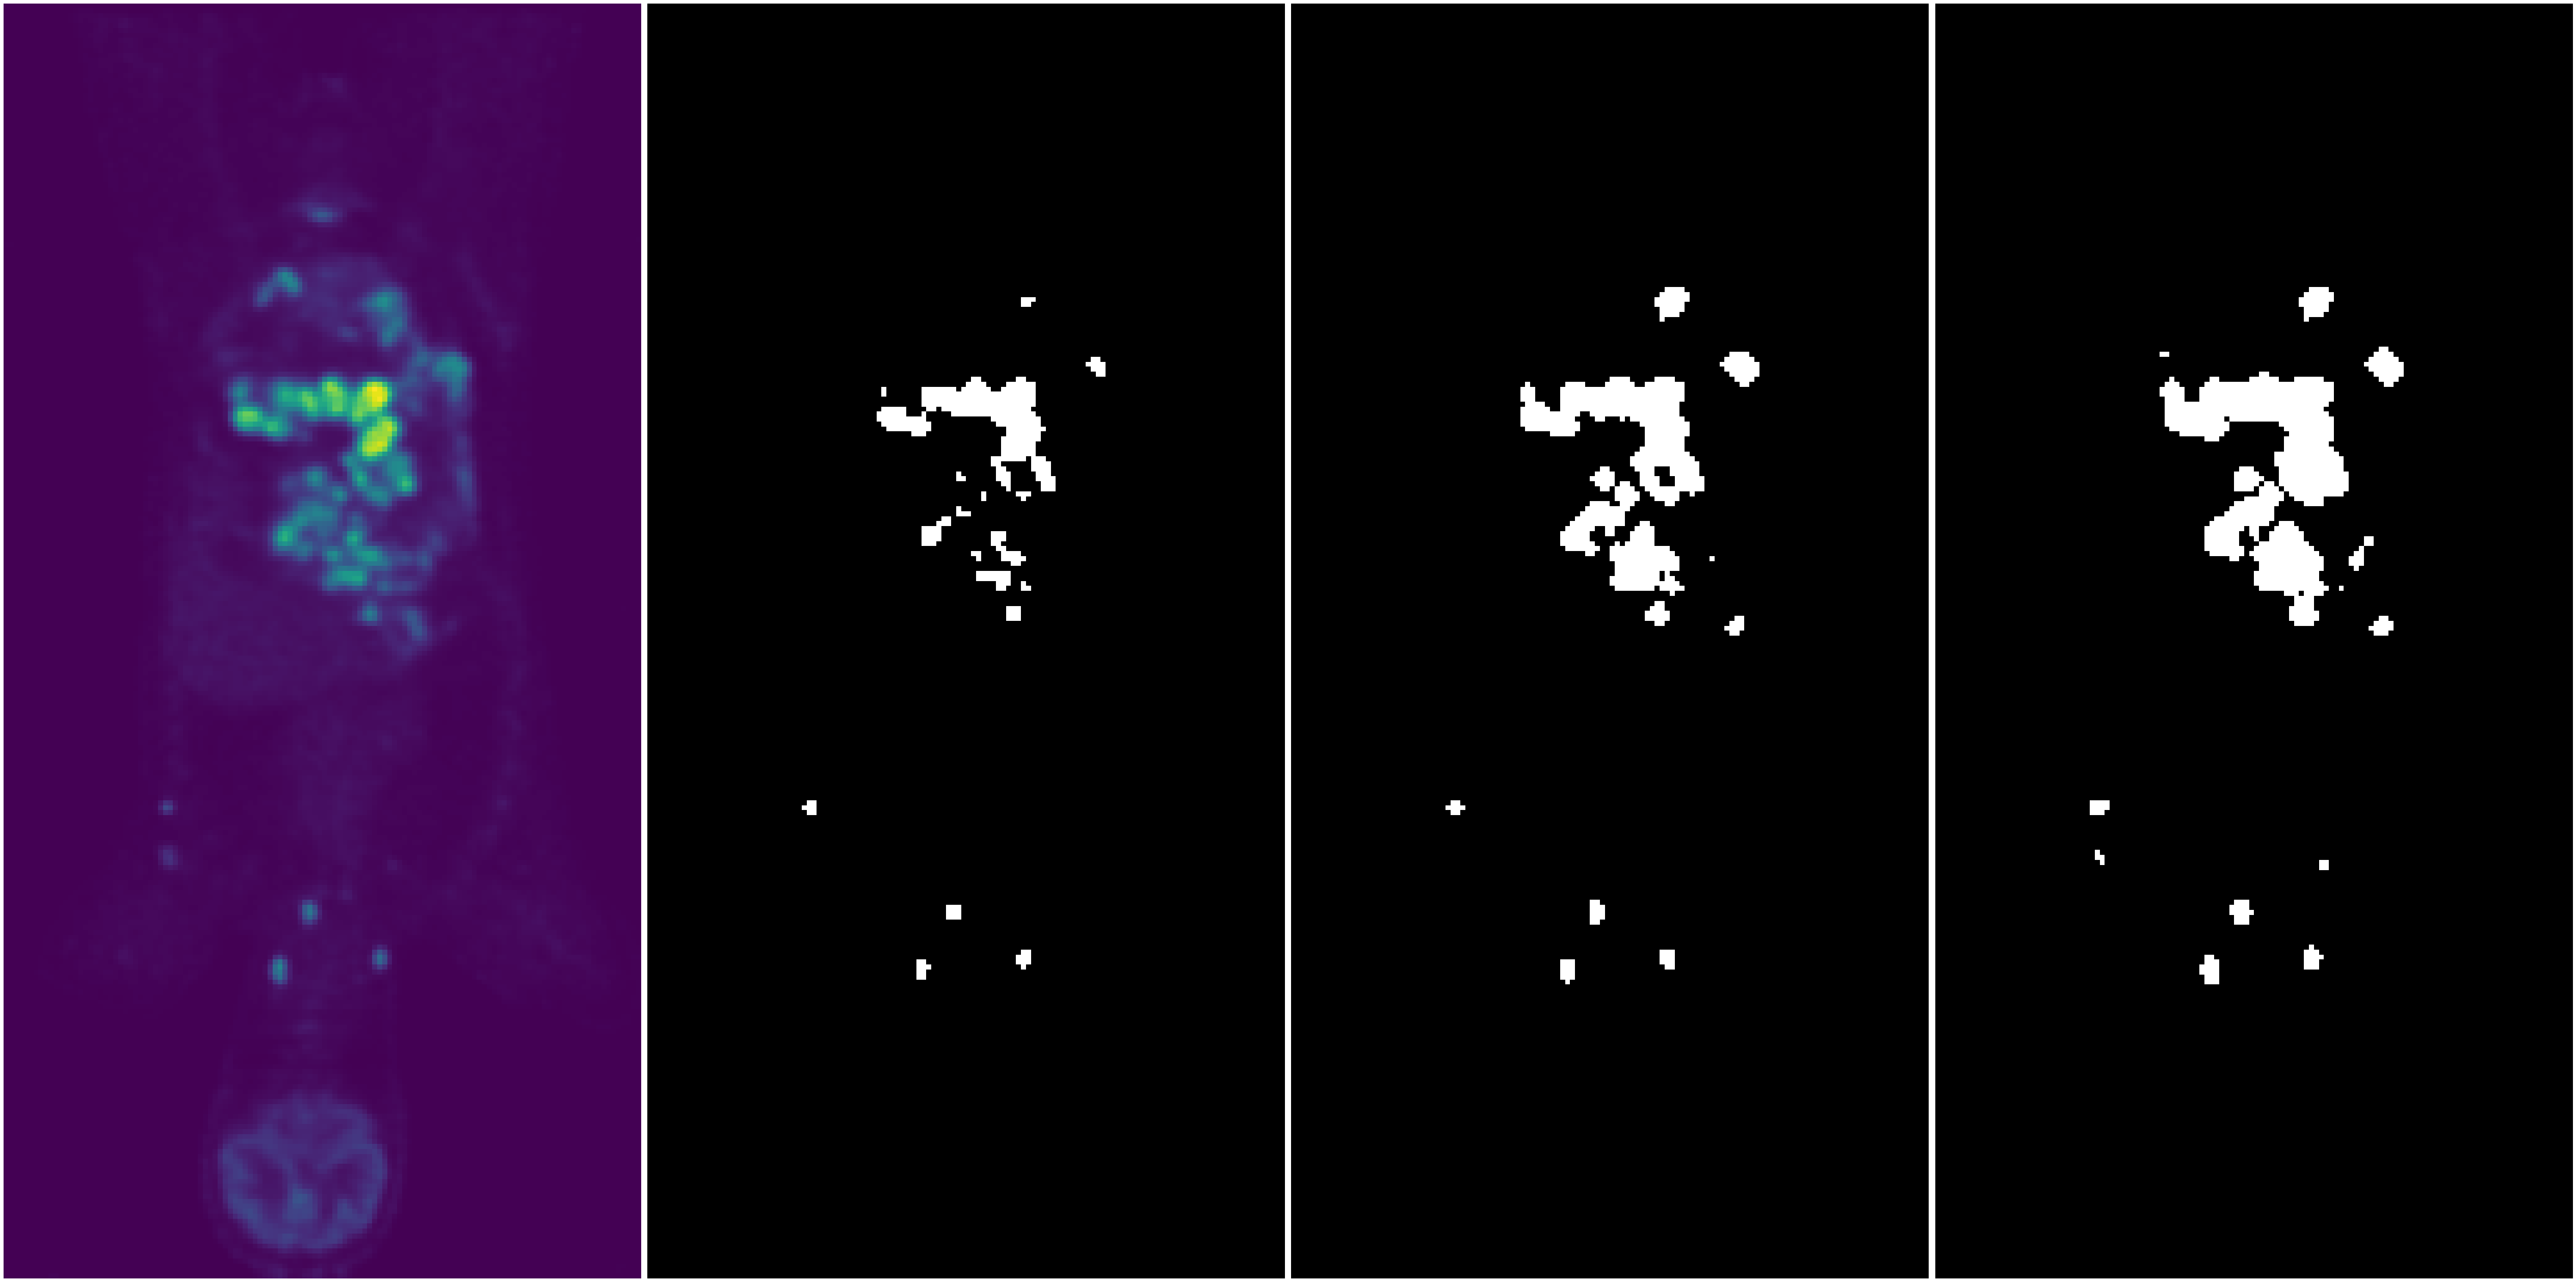

In [13]:
#pet_and_mask_slice=beta+"PeTandMask%i"%i
i=72
mask_img = np.array((test_mask_img[i]>= 1).astype(np.int))
mask_llo_img = np.array((test_mask_llo_img[i]>= 1).astype(np.int))
mask_lo_img = np.array((test_mask_lo_img[i]>= 1).astype(np.int))
plt.figure(figsize=(70,70))
plt.margins(0,0)
plt.subplot(1,4,1)
#plt.title("TEP")
plt.axis('off')
plt.imshow(test_pt_img[i].T)
#plt.imshow(test_pt_img[i])


plt.subplot(1,4,2)
#plt.title("Ground Truth")
plt.axis('off')
plt.imshow(mask_img.T,cmap='gray')


plt.subplot(1,4,3)
#plt.title("TEP")
plt.axis('off')
plt.imshow(mask_llo_img.T,'gray')
#plt.imshow(test_pt_img[i])


plt.subplot(1,4,4)
#plt.title("TEP")
plt.axis('off')
plt.imshow(mask_lo_img.T,'gray')
#plt.imshow(test_pt_img[i])

plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = -0.5, wspace = 0.01)

plt.savefig(os.path.join(r'C:\Users\youve\Dossier Thése\model_chkpoint\predictions',"petandmasksvariant%i"%i+'.png'))

In [ ]:
pet_scan=sorted(glob.glob(data_test_dir+'\\'+'*PET*'))
gt_scan=sorted(glob.glob(data_test_dir+'\\'+'*GT*'))

In [ ]:
# def image_to_test(slices):
#     test_mask_img=[]
#     for path in mask_path[slices[0]:slices[1]]:
#         mask_sitk=sitk.ReadImage(path)
#         masks_np=sitk.GetArrayFromImage(mask_sitk)
#         for i in range(masks_np.shape[1]):
#             test_mask_img.append(masks_np[:,i,:])


#     test_pt_img=[]
#     for path in pt_path[slices[0]:slices[1]]:
#         img_sitk=sitk.ReadImage(path)
#         img_np=sitk.GetArrayFromImage(img_sitk)
#         for i in range(img_np.shape[1]):
#             test_pt_img.append(img_np[:,i,:])
    
#     return test_pt_img,test_mask_img

In [ ]:
def test_pet_mask(cst):
    test_mask_img=[]
    for path in gt_scan:
        mask = nib.load(path).get_data()
        for i in range(mask.shape[1]):
            test_mask_img.append(mask[:,i,:])


    test_pt_img=[]
    for path in pet_scan:
        img = nib.load(path).get_data()
        img /= cst
        for i in range(img.shape[1]):
            test_pt_img.append(img[:,i,:])
            
    return test_mask_img,test_pt_img

In [ ]:
def test_pet_mask_for_beta(cst):
    test_mask_img=[]
    for path in gt_scan:
        mask = nib.load(path).get_data()
        for i in range(mask.shape[2]):
            test_mask_img.append(mask[:,:,i])


    test_pt_img=[]
    for path in pet_scan:
        img = nib.load(path).get_data()
        img /= cst
        for i in range(img.shape[2]):
            test_pt_img.append(img[:,:,i])
            
    return test_mask_img,test_pt_img

In [ ]:
# cst=100
# test_mask_img,test_pt_img=test_pet_mask_for_beta(cst)

In [ ]:
cst=100
test_mask_img,test_pt_img=test_pet_mask(cst)

In [ ]:
#test_pt_img,test_mask_img=image_to_test([100,120])

In [ ]:
desired_shape=(256,256)
good_slices = []
for ary in test_mask_img:
    count_zero = (ary == 0).sum()
    unique, counts = np.unique(ary, return_counts=True)
    p=counts[1:].sum()/count_zero
    good_slices.append(p)
    #print(dict(zip(unique, counts)))
x=dict(zip(good_slices,range(len(test_mask_img))))
best_slices_sorted={k: v for k, v in sorted(x.items(), key=lambda item: float(item[0]))}
 

In [ ]:
best_slices_sorted

In [ ]:
def slices_seleted(i,test_pt_img):
    n_classes=2
    npa_pet=padding(desired_shape,test_pt_img[i])[np.newaxis,np.newaxis]
    return npa_pet


In [ ]:
i=2251
#npa_pet=slices_seleted(i,test_pt_img)
npa_pet=test_pt_img[i][np.newaxis,np.newaxis]

In [ ]:
patient_name="test_slice%i"%i

In [ ]:
npa_pet.shape

In [ ]:
n_classes=2
true_mask = (test_mask_img[i]>= 1).astype(np.int)
pad_true_mask = padding(desired_shape,true_mask).astype(np.int)
y_ohe = one_hot_encoding(pad_true_mask,n_classes)[np.newaxis]
#y_ohe = one_hot_encoding(true_mask,n_classes)[np.newaxis]
y_ohe.shape

In [ ]:
# n_classes=2
# true_mask = (test_mask_img[i]>= 1).astype(np.int)
# #pad_true_mask = padding(desired_shape,true_mask).astype(np.int)
# #y_ohe = one_hot_encoding(true_mask,n_classes)[np.newaxis]
# y_ohe = one_hot_encoding(true_mask,n_classes)[np.newaxis]
# y_ohe.shape

# Baseline model

In [ ]:
test_mask_img,test_pt_img=test_pet_mask(cst)
npa_pet=slices_seleted(i,test_pt_img)
image = torch.from_numpy(npa_pet).float()
mask = torch.from_numpy(y_ohe).float()
#image_ = image.to(device)
reconstruction=model.reconstruct(mask.to(device),image.to(device),mean=True)
sample_full=model.sample(image.to(device))
sample_local=model.sample(image.to(device), mean=[1, 1, 1, 0])
sample_global=model.sample(image.to(device), mean=[0, 1, 1, 1])

pred_local=torch.argmax(sample_local,axis=1)
pred_local=pred_local.clone().cpu().detach().numpy()

pred_global=torch.argmax(sample_global,axis=1)
pred_global=pred_global.clone().cpu().detach().numpy()

pred_full=torch.argmax(sample_full,axis=1)
pred_full=pred_full.clone().cpu().detach().numpy()

pred_reconstruction=torch.argmax(reconstruction,axis=1)
pred_reconstruction=pred_reconstruction.clone().cpu().detach().numpy()

# Baseline model + DeTr 

In [ ]:
# test_mask_img,test_pt_img=test_pet_mask(cst)
# npa_pet=slices_seleted(i,test_pt_img)
# image = torch.from_numpy(npa_pet).float()
# mask = torch.from_numpy(y_ohe).float()
# #image_ = image.to(device)
# reconstruction=model.reconstruct(mask.to(device),image.to(device),mean=True)
# sample_full,df=model.sample_and_detect(image.to(device))
# sample_local,dl=model.sample_and_detect(image.to(device), mean=[1, 1, 1, 0])
# sample_global,dg=model.sample_and_detect(image.to(device), mean=[0, 1, 1, 1])

# pred_local=torch.argmax(sample_local,axis=1)
# pred_local=pred_local.clone().cpu().detach().numpy()

# pred_global=torch.argmax(sample_global,axis=1)
# pred_global=pred_global.clone().cpu().detach().numpy()

# pred_full=torch.argmax(sample_full,axis=1)
# pred_full=pred_full.clone().cpu().detach().numpy()

# pred_reconstruction=torch.argmax(reconstruction,axis=1)
# pred_reconstruction=pred_reconstruction.clone().cpu().detach().numpy()

# For Beta's

In [ ]:
# test_mask_img,test_pt_img=test_pet_mask_for_beta(cst)
# #npa_pet=slices_seleted(i,test_pt_img)
# image = torch.from_numpy(npa_pet).float()
# mask = torch.from_numpy(y_ohe).float()
# #image_ = image.to(device)
# reconstruction=model.reconstruct(mask.to(device),image.to(device),mean=True)
# sample_full=model.sample(image.to(device))
# sample_local=model.sample(image.to(device), mean=[1, 1, 1, 0])
# sample_global=model.sample(image.to(device), mean=[0, 1, 1, 1])

# pred_local=torch.argmax(sample_local,axis=1)
# pred_local=pred_local.clone().cpu().detach().numpy()

# pred_global=torch.argmax(sample_global,axis=1)
# pred_global=pred_global.clone().cpu().detach().numpy()

# pred_full=torch.argmax(sample_full,axis=1)
# pred_full=pred_full.clone().cpu().detach().numpy()

# pred_reconstruction=torch.argmax(reconstruction,axis=1)
# pred_reconstruction=pred_reconstruction.clone().cpu().detach().numpy()

In [ ]:
pet_and_mask_slice=beta+"PeTandMask%i"%i
plt.figure(figsize=(70,70))
plt.margins(0,0)
plt.subplot(1,6,1)
plt.title("TEP")
plt.axis('off')
plt.imshow(npa_pet[0,0,:,:])
#plt.imshow(test_pt_img[i])


plt.subplot(1,6,2)
plt.title("Ground Truth")
plt.axis('off')
plt.imshow(pad_true_mask,cmap='gray')
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = -0.5, wspace = 0.01)

plt.savefig(os.path.join(r'C:\Users\youve\Dossier Thése\model_chkpoint\predictions',pet_and_mask_slice+'.png'))



In [ ]:
plt.figure(figsize=(30,10))
plt.subplot(1,6,3)
plt.title("sample_full")
plt.axis('off')
plt.imshow(pred_full[0])

plt.subplot(1,6,4)
plt.title("sample_local")
plt.axis('off')
plt.imshow(pred_local[0])


plt.subplot(1,6,5)
plt.title("sample_global")
plt.axis('off')
plt.imshow(pred_global[0])

plt.subplot(1,6,6)
plt.title("reconstruction")
plt.axis('off')
plt.imshow(pred_reconstruction[0])


In [ ]:
def pred_samples(numbers_samples,image):
    num_samples=numbers_samples
    samples=[]
    for i in range(num_samples):
        sample=model.sample(image.to(device))
        sample_sm=torch.sigmoid(sample)
        pred=torch.argmax(sample_sm,axis=1)
        pred=pred.clone().cpu().detach().numpy()
        samples.append(pred)

    samples_global=[]
    for i in range(num_samples):
        sample=model.sample(image.to(device), mean=[0, 1, 1, 1])
        sample_sm=torch.sigmoid(sample)
        pred=torch.argmax(sample_sm,axis=1)
        pred=pred.clone().cpu().detach().numpy()
        samples_global.append(pred)


    samples_local=[]
    for i in range(num_samples):
        sample=model.sample(image.to(device), mean=[1, 1, 1, 0])
        sample_sm=torch.sigmoid(sample)
        pred=torch.argmax(sample_sm,axis=1)
        pred=pred.clone().cpu().detach().numpy()
        samples_local.append(pred)
        
    return samples,samples_global,samples_local

In [ ]:
numbers_samples=15
#samples,samples_global,samples_local=pred_samples(numbers_samples)

In [ ]:
def npa_samples(i,cst):
    test_mask_img,test_pt_img=test_pet_mask(cst)
    npa_pet=slices_seleted(i,test_pt_img)
    #npa_pet=test_pt_img[i][np.newaxis,np.newaxis]
    image_pet = torch.from_numpy(npa_pet).float()
    samples,samples_global,samples_local=pred_samples(numbers_samples,image_pet)
    
    
#     samples=torch.from_numpy(np.array(samples_local))
#     sample_sm=torch.sigmoid(samples)
#     pred=torch.argmax(sample_sm,axis=2)
#     pred=pred.clone().cpu().detach().numpy()
    return samples

In [ ]:
def npa_samples_for_beta(i,cst):
    test_mask_img,test_pt_img=test_pet_mask_for_beta(cst)
    #npa_pet=slices_seleted(i,test_pt_img)
    npa_pet=test_pt_img[i][np.newaxis,np.newaxis]
    image_pet = torch.from_numpy(npa_pet).float()
    samples,samples_global,samples_local=pred_samples(numbers_samples,image_pet)
    
    
#     samples=torch.from_numpy(np.array(samples_local))
#     sample_sm=torch.sigmoid(samples)
#     pred=torch.argmax(sample_sm,axis=2)
#     pred=pred.clone().cpu().detach().numpy()
    return samples

In [ ]:
# samples=npa_samples(i,200)
# samples_2=npa_samples(i,210)
# samples_3=npa_samples(i,220)
# samples_4=npa_samples(i,190)
# samples_5=npa_samples(i,180)

In [ ]:
#i=844
samples=npa_samples(i,100)
samples_2=npa_samples(i,110)
samples_3=npa_samples(i,120)
samples_4=npa_samples(i,90)
samples_5=npa_samples(i,80)

In [ ]:
# samples=npa_samples(i,105)
# samples_2=npa_samples(i,110)
# samples_3=npa_samples(i,115)
# samples_4=npa_samples(i,95)
# samples_5=npa_samples(i,100)

In [ ]:
def shuffle_along_axis(a, axis):
    idx = np.random.rand(*a.shape).argsort(axis=axis)
    return np.take_along_axis(a,idx,axis=axis)

In [ ]:
all_samples=np.concatenate([samples,
samples_2,
samples_3,
samples_4,
samples_5])

In [ ]:
np.unique(all_samples)

In [ ]:
all_samples=shuffle_along_axis(all_samples,axis=0)

In [ ]:
all_samples.shape

In [ ]:
def mean_and_std(samples):
    std=np.std(samples,axis=0)
    mean=np.mean(samples,axis=0)
    return std,mean

In [ ]:
std,mean=mean_and_std(all_samples)

In [ ]:
np.where(std)

In [ ]:
patient_name="test_slice%i"%i

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)

plt.imshow(std[0],cmap=plt.get_cmap('jet'))
plt.title("std images")
plt.axis('off')
plt.colorbar()
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(mean[0],cmap=plt.get_cmap('jet'))
plt.title("mean images")
plt.colorbar()
plt.savefig(os.path.join(r'C:\Users\youve\Dossier Thése\model_chkpoint\predictions',"mean_std"+"HPUNET"+patient_name+'.png'))

In [ ]:
fig=plt.figure(figsize=(50, 50))
columns = 3
rows = 5
for i in range(1, columns*rows +1):
    img = all_samples[i,0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(img,cmap='gray')
plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0.01, wspace = -0.66)

plt.savefig(os.path.join(r'C:\Users\youve\Dossier Thése\model_chkpoint\predictions',"HPUNET"+patient_name+'.png'))

plt.show()

In [ ]:
patient_name="test_slice%i"%i
fig=plt.figure(figsize=(50, 50))
columns = 3
rows = 5
for i in range(1, columns*rows +1):
    img = all_samples[i,0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(img,cmap='gray')
plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0.01, wspace = -0.66)

#plt.savefig(os.path.join(r'C:\Users\youve\Dossier Thése\model_chkpoint\predictions',beta+"DeTr"+patient_name+'.png'))

plt.show()

In [ ]:
patient_name="test_slice%i"%i
fig=plt.figure(figsize=(50, 50))
columns = 3
rows = 5
for i in range(1, columns*rows +1):
    img = all_samples[i,0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(img,cmap='gray')
plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = -0.5, wspace = 0.01)

#plt.savefig(os.path.join(r'C:\Users\youve\Dossier Thése\model_chkpoint\predictions',beta+"DeTr"+patient_name+'.png'))

plt.show()

In [ ]:
# patient_name="test_slice%i"%i
# fig=plt.figure(figsize=(50, 50))
# columns = 3
# rows = 5
# for i in range(1, columns*rows +1):
#     img = all_samples[i,0,:,:]
#     fig.add_subplot(rows, columns, i)
#     plt.axis('off')
#     plt.imshow(img,cmap='gray')
# plt.gca().set_axis_off()
# plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
#             hspace = -0.5, wspace = 0.01)

# #plt.savefig(os.path.join(r'C:\Users\youve\Dossier Thése\model_chkpoint\predictions',beta+"DeTr"+patient_name+'.png'))

# plt.show()

# Compute metrics for models 

In [ ]:
def batch_dice_per_class(pred,gt,n_classes):
    pred = one_hot_encoding(pred,n_classes)
    gt = one_hot_encoding(gt,n_classes)
    axis = tuple(range(2,len(pred.shape)))
    inter = np.sum(pred*gt,axis=axis)
    denominateur = np.sum(pred,axis=axis)+np.sum(gt,axis=axis) + 1e-9
    dice = 2.0*inter/denominateur
    return dice


In [ ]:
def sen_spe(class_pred,class_label):

    tp = np.sum( (class_pred == 1) * (class_label == 1))

    # true negatives
    tn = np.sum( (class_pred == 0) * (class_label == 0))

    #false positives
    fp = np.sum( (class_pred == 1) * (class_label == 0))

    # false negatives
    fn =  np.sum( (class_pred == 0) * (class_label == 1))

    # compute sensitivity and specificity
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    ### END CODE HERE ###

    return sensitivity, specificity


In [ ]:
def pet_and_mask(cst):
    test_mask_img=[]
    for path in gt_scan:
        mask=nib.load(path).get_data()
        masks=[mask[:,i,:] for i in range(mask.shape[1])]


    test_pt_img=[]
    for path in pet_scan:
        img = nib.load(path).get_data()
        img /= cst
        imgs=[img[:,i,:] for i in range(img.shape[1])]
            
    return test_mask_img,test_pt_img

In [ ]:
def pet_and_mask(cst,gt_path,pt_path):
    
    mask=nib.load(gt_path).get_data()
    masks=[mask[:,i,:] for i in  range(mask.shape[1])]


    img = nib.load(pt_path).get_data()
    img /= cst
    imgs=[img[:,i,:] for i in range(img.shape[1])]
            
    return imgs,masks

In [ ]:
desired_shape=(256,256)

In [ ]:
def get_one_hot_encoding(y, n_classes):
    """
    transform a numpy label array to a one-hot array of the same shape.
    :param y: array of shape (b, 1, y, x, (z)).
    :param n_classes: int, number of classes to unfold in one-hot encoding.
    :return y_ohe: array of shape (b, n_classes, y, x, (z))
    """
    dim = len(y.shape) - 2
    if dim == 2:
        y_ohe = np.zeros((y.shape[0], n_classes, y.shape[2], y.shape[3])).astype('int32')
    if dim ==3:
        y_ohe = np.zeros((y.shape[0], n_classes, y.shape[2], y.shape[3], y.shape[4])).astype('int32')
    for cl in range(n_classes):
        y_ohe[:, cl][y[:, 0] == cl] = 1
    return y_ohe



def get_dice_per_batch_and_class(pred, y, n_classes):
    '''
    computes dice scores per batch instance and class.
    :param pred: prediction array of shape (b, 1, y, x, (z)) (e.g. softmax prediction with argmax over dim 1)
    :param y: ground truth array of shape (b, 1, y, x, (z)) (contains int [0, ..., n_classes]
    :param n_classes: int
    :return: dice scores of shape (b, c)
    '''
    pred = get_one_hot_encoding(pred, n_classes)
    y = get_one_hot_encoding(y, n_classes)
    axes = tuple(range(2, len(pred.shape)))
    intersect = np.sum(pred*y, axis=axes)
    denominator = np.sum(pred, axis=axes)+np.sum(y, axis=axes) + 1e-8
    dice = 2.0*intersect / denominator
    return dice

In [ ]:
def pet_and_mask_for_beta(cst,gt_path,pt_path):
    
    mask=nib.load(gt_path).get_data()
    masks=[mask[:,:,i] for i in  range(mask.shape[2])]


    img = nib.load(pt_path).get_data()
    img /= cst
    imgs=[img[:,:,i] for i in range(img.shape[2])]
            
    return imgs,masks

In [ ]:
pt_img,mask_img=pet_and_mask_for_beta(cst,gt_scan[17],pet_scan[17])

In [ ]:
len(pt_img)

In [ ]:
npa_mask=np.array(mask_img)
npa_mask=npa_mask[:,np.newaxis,...]
npa_mask=(npa_mask>= 1).astype(np.int)

In [ ]:
def slices_seleted(i,test_pt_img):
    npa_pet=padding(desired_shape,test_pt_img[i])[np.newaxis,np.newaxis]
    return npa_pet

In [ ]:
def dice_and_ss_over_samples(cst,index_patient):
    pt_img,mask_img=pet_and_mask(cst,gt_scan[index_patient],pet_scan[index_patient])
    npa_mask=np.array(mask_img)
    npa_mask=npa_mask[:,np.newaxis,...]
    npa_mask=(npa_mask>= 1).astype(np.int)
    dice=[]
    mean_d=[]
    ss=[]
    number_of_samples=15
    for i in range(number_of_samples):
        prediction=[]
        with torch.no_grad():
            for i in range(len(pt_img)):
                test = torch.from_numpy(slices_seleted(i,pt_img)).float()
                pred=model.sample(test.to(device))
                pred=torch.sigmoid(pred)
                pred=torch.argmax(pred,axis=1)
                pred=pred.clone().cpu().detach().numpy()
                prediction.append(pred)
            prediction=np.array(prediction)

            ss.append(sen_spe(prediction[:,:,0:128,:],npa_mask))
            #ss.append(sen_spe(prediction[:,:,0:128,0:128],npa_mask))

            for e in get_dice_per_batch_and_class(prediction[:,:,0:128,:],npa_mask, 2):
            #for e in get_dice_per_batch_and_class(prediction[:,:,0:128,0:128],npa_mask, 2):    
                sum_e=sum(e)
                if sum_e==0.9999999999998475:
                    pass
                else:
                    dice.append(e)

            mean_dice=np.mean(dice)
            mean_d.append(mean_dice)
    return ss,mean_d



In [ ]:
all_patient_dice=[]
all_patient_ss=[]
for index_patient in range(15,len(pet_scan)):
    print(index_patient)
    for cst in [80,90,100,110,120]:
        ss,mean_d=dice_and_ss_over_samples(cst,index_patient)
        all_patient_dice.append(mean_d)
        all_patient_ss.append(ss)

In [ ]:
np.save('all_patient_dice_withDetr.npy', all_patient_dice) 

In [ ]:
np.save('all_patient_ss_withDetr.npy', all_patient_ss)

In [ ]:
all_patient_dice=np.load('all_patient_dice_256256.npy')
all_patient_ss=np.load('all_patient_ss_256256.npy')

In [ ]:
def pp_spe_sen(all_patient_ss):
    pp_sen=[]
    pp_spe=[]
    for i in range(len(all_patient_ss)):
        pp_sen.append([e[0] for e in all_patient_ss[i]])
        pp_spe.append([e[1] for e in all_patient_ss[i]])
    return pp_sen,pp_spe
    

In [ ]:
def pp_sen_spe_mean(all_patient_ss):
    pp_sen,pp_spe=pp_spe_sen(all_patient_ss)
    pp_sen_mean=[np.mean(pp_sen[i:i+5],axis=0) for i in range(0,80,5)]
    pp_spe_mean=[np.mean(pp_spe[i:i+5],axis=0) for i in range(0,80,5)]
    return pp_sen_mean,pp_spe_mean

In [ ]:
pp_dice_mean=[np.mean(all_patient_dice[i:i+5],axis=0) for i in range(0,80,5)]

In [ ]:
def var_mean(pp):
    return np.mean(pp),np.std(pp)

In [ ]:
mean_dice,std_dice=var_mean(pp_dice_mean)
mean_sen,std_sen=var_mean(pp_sen_mean)
mean_spe,std_spe=var_mean(pp_spe_mean)

In [ ]:
mean_sen,std_sen

In [ ]:
mean_spe,std_spe

In [ ]:
mean_dice,std_dice

In [ ]:
green_diamond = dict(markerfacecolor='g', marker='D')
fig=plt.figure(figsize=(30, 15))
columns = 5
rows = 3
for i in range(1, columns*rows +1):
    data = pp_dice_mean[i]
    fig.add_subplot(rows, columns, i)
    #plt.axis('off')
    plt.boxplot(data,flierprops=green_diamond)
    plt.title("Patient test %i"%i,loc='right')
#plt.gca().set_axis_off()
#plt.subplots_adjust(top = 1, bottom = 0.5, right = 2.0, left = 0.5, 
            #hspace = 0.5, wspace = 0.4)
plt.savefig(os.path.join(r'C:\Users\youve\Dossier Thése\model_chkpoint\predictions','dice_pp'+"256256"+'.png'))
